# Bundle Profile Reliablity and Streamline Alignment

<span style="color:blue">**TODO: Provide some context and description of problem**</span>

## Targeting Conference Abstract Deadlines 

- [(ISMRM) International Society for Magnetic Resonance in Medicine](https://www.ismrm.org/21m/)

  - focused on general MRI methodology
  
  **Deadline December 16, 2020 at 23:59 EST**

## Task List:

### 1. Additional subjects

  CloudKnot implementation. -- Do inital results hold for more subjects?

### 2. Alternative reference for DTW

  Currently using mean streamline, could use a mean weighted streamline as in `afq_profile`, or QuickBundle centriod

## Streamline Alignment

**Streamlines do not have the same length:**
 
- There are several approaches to align streamlines, and these choices can affect results.

  - Default is to sample uniform number of points from each streamline
  
    - While this allows for comparison across streamlines, it also will warp distance.
    
    - This could mean that if there are short and long streamlines the short streamline may align to a segment of the long streamline, but the streamline profile will not capture this.
    
**Streamlines do not necessarily begin and end in same regions**

**Streamlines may not terminate in or near gray matter**

### Methods

There are several methods for aligning streamlines to calculate bundle profiles:

- sampling/indexing (`set_number_of_points`)

  - raw average across streamlines
  
  - AFQ uses `gaussian_weights(streamlines)` (weighted averaging)

- segmentation (like `buan`)

  - BUAN approach (segmentation)

- warping

  - Warped streamlines profiles (using DTW)

    - using reference (mean, weighted average)
  
    - pairwise

We would like to compare these methods.

To determine which improves performance will look at test-retest reliabilty in HCP dataset.

## Steps

1. get HCP and HCP_retest data

2. get bundle profiles for test-retest subjects

3. cacluate test-retest reliabilty

  1. Profile reliability
  
  2. Subject reliability

4. Calculate DTW using

  1. reference streamline:
  
    - Mean
    
    - Weighted mean
  
  2. Pairwise
  
5. Once code is working port to CloudKnot (AWS)

In [1]:
import os
import os.path as op
import time

from itertools import chain

import numpy as np
import pandas as pd

from AFQ import api
import AFQ.data as afd

import nibabel as nib

from dipy.io.streamline import load_tractogram
from dipy.stats.analysis import afq_profile, gaussian_weights
from dipy.tracking.streamline import set_number_of_points, values_from_volume

from scipy.interpolate import splprep, splev

from fastdtw import fastdtw

# %matplotlib widget

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

/Users/bloomdt/anaconda/envs/dtw/lib/python3.8/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Retrieve HCP Data

In [2]:
hcp_subjects = ['103818', '105923']

In [3]:
retrieve_data = False

if retrieve_data:
    # ==== download test data ===
    afd.fetch_hcp(hcp_subjects)
    
    # ==== download retest data ===
    afd.fetch_hcp(hcp_subjects, study='HCP_Retest')

In [4]:
fetch_s3 = False

if fetch_s3:
    for subject in hcp_subjects:
        # ==== download test data ===
        subject_base_dir = op.join(afd.afq_home, 'HCP_1200', 'derivatives', 'afq', f'sub-{subject}')

        if not os.path.isdir(subject_base_dir):
            os.makedirs(subject_base_dir)
            hcp_s3_url = f's3://profile-hcp-west/hcp_reliability/single_shell/hcp_1200_afq/sub-{subject}/'
        
            !aws s3 cp {hcp_s3_url} {subject_base_dir} --recursive
        else:
            print(subject, "test data already downloaded")
        
        # ==== download retest data ===
        subject_base_dir = op.join(afd.afq_home, 'hcp_retest', 'derivatives', 'afq', f'sub-{subject}')

        if not os.path.isdir(subject_base_dir):
            os.makedirs(subject_base_dir)
            hcp_s3_url = f's3://profile-hcp-west/hcp_reliability/single_shell/hcp_retest_afq/sub-{subject}/'
        
            !aws s3 cp {hcp_s3_url} {subject_base_dir} --recursive
        else:
            print(subject, "retest data already downloaded")

## AFQ

In [5]:
def get_hcp_afq(dataset_name):
    afq = api.AFQ(
        bids_path=op.join(afd.afq_home, dataset_name),
        dmriprep='dmriprep'
    )
    
    display(afq.data_frame)
    
    return afq

hcp_test_afq = get_hcp_afq('HCP_1200')

hcp_retest_afq = get_hcp_afq('hcp_retest')

INFO:dipy.data.fetcher:Dataset is already in place. If you want to fetch it again please first remove the folder /Users/bloomdt/AFQ_data/templates 
INFO:dipy.data.fetcher:Dataset is already in place. If you want to fetch it again please first remove the folder /Users/bloomdt/AFQ_data/callosum_templates 
/Users/bloomdt/anaconda/envs/dtw/lib/python3.8/site-packages/bids/layout/models.py:98: FutureWarning: The 'extension' entity currently excludes the leading dot ('.'). As of version 0.14.0, it will include the leading dot. To suppress this warning and include the leading dot, use `bids.config.set_option('extension_initial_dot', True)`.
  warnings.warn("The 'extension' entity currently excludes the leading dot ('.'). "


,subject,dwi_file,bvec_file,bval_file,custom_tract,reg_subject,ses,timing,results_dir,gtab,dwi_affine,dwi_img
0,100307,/Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...,/Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...,/Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...,None,None,01,"{'Tractography': 0, 'Registration': 0, 'Segmen...",/Users/bloomdt/AFQ_data/HCP_1200/derivatives/a...,<dipy.core.gradients.GradientTable object at 0...,"[[-1.25, 0.0, 0.0, 90.0], [0.0, 1.25, 0.0, -12...",<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...
1,103818,/Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...,/Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...,/Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...,None,None,01,"{'Tractography': 0, 'Registration': 0, 'Segmen...",/Users/bloomdt/AFQ_data/HCP_1200/derivatives/a...,<dipy.core.gradients.GradientTable object at 0...,"[[-1.25, 0.0, 0.0, 90.0], [0.0, 1.25, 0.0, -12...",<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...
2,105923,/Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...,/Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...,/Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...,None,None,01,"{'Tractography': 0, 'Registration': 0, 'Segmen...",/Users/bloomdt/AFQ_data/HCP_1200/derivatives/a...,<dipy.core.gradients.GradientTable object at 0...,"[[-1.25, 0.0, 0.0, 90.0], [0.0, 1.25, 0.0, -12...",<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...


INFO:dipy.data.fetcher:Dataset is already in place. If you want to fetch it again please first remove the folder /Users/bloomdt/AFQ_data/templates 
INFO:dipy.data.fetcher:Dataset is already in place. If you want to fetch it again please first remove the folder /Users/bloomdt/AFQ_data/callosum_templates 
/Users/bloomdt/anaconda/envs/dtw/lib/python3.8/site-packages/bids/layout/models.py:98: FutureWarning: The 'extension' entity currently excludes the leading dot ('.'). As of version 0.14.0, it will include the leading dot. To suppress this warning and include the leading dot, use `bids.config.set_option('extension_initial_dot', True)`.
  warnings.warn("The 'extension' entity currently excludes the leading dot ('.'). "


,subject,dwi_file,bvec_file,bval_file,custom_tract,reg_subject,ses,timing,results_dir,gtab,dwi_affine,dwi_img
0,103818,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,None,None,01,"{'Tractography': 0, 'Registration': 0, 'Segmen...",/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,<dipy.core.gradients.GradientTable object at 0...,"[[-1.25, 0.0, 0.0, 90.0], [0.0, 1.25, 0.0, -12...",<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...
1,105923,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,None,None,01,"{'Tractography': 0, 'Registration': 0, 'Segmen...",/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,<dipy.core.gradients.GradientTable object at 0...,"[[-1.25, 0.0, 0.0, 90.0], [0.0, 1.25, 0.0, -12...",<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...


### AFQ Wrappers and Data

In [6]:
bundle_names = [*hcp_retest_afq.bundle_dict]
# bundle_names = ['SLF_L', 'SLF_R'] 

In [7]:
n_points = 100

In [8]:
def get_subject_iloc(afq, subject):
    iloc = afq.data_frame.index[afq.data_frame['subject'] == subject][0]
    
    return iloc

def get_subject_scalar_data(afq, subject, scalar):
    iloc = get_subject_iloc(afq, subject)
    
    scalar_filename = afq._get_fname(
        afq.data_frame.iloc[iloc],
        f'_model-{scalar}.nii.gz'
    )

    scalar_data = nib.load(scalar_filename).get_fdata()
    
    return scalar_data

def get_subject_bundle_tractogram(afq, subject, bundle_name):
    iloc = get_subject_iloc(afq, subject)
    
    results_dir = afq.data_frame.iloc[iloc]['results_dir']
    
    fname = op.split(
        afq._get_fname(
            afq.data_frame.iloc[iloc],
            f'-{bundle_name}'
            f'_tractography.trk',
            include_track=True,
            include_seg=True
        )
    )

    tractogram_filename = op.join(results_dir, 'clean_bundles', fname[1])
    
    tractogram = load_tractogram(tractogram_filename, 'same')
    
    return tractogram

## Baseline Bundle Profiles and Correlations

In [9]:
show_intermediate_correlations = False

In [10]:
def get_subject_bundle_profile(afq, subject, scalar_data, bundle_name, show_streamline_profiles=False):
    tractogram = get_subject_bundle_tractogram(afq, subject, bundle_name)

    if len(tractogram.streamlines) == 0:
        print(subject, bundle_name, 'no streamlines!')
        return np.zeros(n_points)
    
    if show_streamline_profiles:
        fgarray = set_number_of_points(tractogram.streamlines, n_points)
        values = np.array(values_from_volume(scalar_data, fgarray, tractogram.affine))
        mean_values = np.mean(values, axis=0)
        
        plt.figure()
        plt.title(f'{subject} {bundle_name} streamline profiles')
        plt.plot(values.T, c='tab:blue', alpha=0.1)
        plt.plot(mean_values.T, c='black', label='$\mu$')
        plt.legend()
        plt.show()
            
    profile = afq_profile(
        scalar_data,
        tractogram.streamlines,
        tractogram.affine,
        weights=gaussian_weights(tractogram.streamlines)
    )
    
    return profile

def get_bundle_profiles(afq):
    bundle_profiles = {}
    
    for subject in hcp_subjects:
        bundle_profiles[subject] = {}
    
        for scalar in afq.scalars:
            bundle_profiles[subject][scalar] = {}
            scalar_data = get_subject_scalar_data(afq, subject, scalar)
            
            for bundle_name in bundle_names:
#                 bundle_profiles[subject][scalar][bundle_name] = get_subject_bundle_profile(afq, subject, scalar_data, bundle_name, bundle_name == 'SLF_L')
                bundle_profiles[subject][scalar][bundle_name] = get_subject_bundle_profile(afq, subject, scalar_data, bundle_name)

    return bundle_profiles

def get_test_retest_bundle_profile_correlations(show_bundle_profile=False, show_correlations=False):
    correlations = {}

    print('test')
    test_bundle_profiles = get_bundle_profiles(hcp_test_afq)
    display(pd.DataFrame.from_dict(test_bundle_profiles))

    print('retest')
    retest_bundle_profiles = get_bundle_profiles(hcp_retest_afq)
    display(pd.DataFrame.from_dict(retest_bundle_profiles))

    for scalar in hcp_retest_afq.scalars:
        correlations[scalar] = {}
        for subject in hcp_subjects:
            correlations[scalar][subject] = {}
            for bundle_name in bundle_names:
                test_profile = test_bundle_profiles[subject][scalar][bundle_name]
                retest_profile = retest_bundle_profiles[subject][scalar][bundle_name]

                if show_bundle_profile:
#                 if show_bundle_profile or bundle_name == 'SLF_L':
                    plt.figure()
                    plt.title(f'{scalar} {subject} {bundle_name} bundle profiles')
                    plt.plot(test_profile, label='test')
                    plt.plot(retest_profile, label='retest')
                    plt.xlabel('index')
                    plt.ylabel(scalar)
                    plt.legend()
                    plt.show()

                test_retest_corr_matrix = pd.DataFrame(zip(*[test_profile, retest_profile]), columns=['test', 'retest']).corr()
                
                # select only the upper triangle off diagonals of the correlation matrix
                test_retest_corr = test_retest_corr_matrix.where(np.triu(np.ones(test_retest_corr_matrix.shape), 1).astype(np.bool)).stack()
                
                if show_correlations:
                    print(scalar, subject, bundle_name, 'test-retest correlation:\n', test_retest_corr)
                
                if len(test_retest_corr) == 1:
                    correlations[scalar][subject][bundle_name] = test_retest_corr[0]
                else:
                    correlations[scalar][subject][bundle_name] = 0
                
    return correlations

In [11]:
correlations = get_test_retest_bundle_profile_correlations()

test
105923 ARC_R no streamlines!
105923 ARC_R no streamlines!


,103818,105923
dti_fa,"{'ATR_R': [0.2144683273120771, 0.2741186021085...","{'ATR_R': [0.21419657534304493, 0.264675593637..."
dti_md,"{'ATR_R': [0.0008419183109128342, 0.0008365659...","{'ATR_R': [0.0008736491941856806, 0.0008977903..."


retest
105923 ARC_R no streamlines!
105923 ARC_R no streamlines!


,103818,105923
dti_fa,"{'ATR_R': [0.21572252326657787, 0.285696309983...","{'ATR_R': [0.21579807978356796, 0.273354791867..."
dti_md,"{'ATR_R': [0.0008881062496957959, 0.0008634534...","{'ATR_R': [0.0008763236553443433, 0.0008799265..."


### Profile reliability

In [12]:
fa_correlations = pd.DataFrame.from_dict(correlations['dti_fa'])

if show_intermediate_correlations:
    display(fa_correlations.T)

    ax = fa_correlations.T.hist(figsize=(15, 15))

In [13]:
fa_correlations_agg = fa_correlations.agg(['mean', 'std'], axis=1)
fa_correlations_agg['double_std'] = 2 * fa_correlations_agg['std']

median = fa_correlations_agg['mean'].median(axis=0)
fa_correlations_agg = fa_correlations_agg.append(pd.Series(name='median', dtype=float))
fa_correlations_agg.at['median', 'mean'] = median

if show_intermediate_correlations:
    display(fa_correlations_agg.T)

    ax = fa_correlations_agg.plot.bar(y='mean', yerr='double_std')

## Mean Warped Bundle Profiles and Correlations

In [14]:
def get_subject_mean_warped_bundle_profile(afq, subject, scalar_data, bundle_name, show_dtw_streamline_profiles=False):
    tractogram = get_subject_bundle_tractogram(afq, subject, bundle_name)
    
    if len(tractogram.streamlines) == 0:
        print(subject, bundle_name, 'no streamlines!')
        return np.zeros(n_points)
    
    fgarray = set_number_of_points(tractogram.streamlines, n_points)

    values = np.array(values_from_volume(scalar_data, fgarray, tractogram.affine))
    mean_values = np.mean(values, axis=0)

    tic = time.perf_counter()
    dtw_values = []

    for value in values:
        dist, path = fastdtw(value, mean_values)
        path = np.array(path)
        dtw_values.append(value[np.append(path[np.where(path[:,1][:-1] != path[:,1][1:]),0][0], len(values.T)-1)])

    dtw_values = np.array(dtw_values)
    toc = time.perf_counter()
#     print(f'dtw calculation {toc - tic:0.4f} seconds')
#     print(dtw_values.shape)

    dtw_mean_values = np.mean(dtw_values, axis=0)

    if show_dtw_streamline_profiles:
        plt.figure()
        plt.title(f'{subject} {bundle_name} $\mu$-reference warped streamline profiles')
        plt.plot(dtw_values.T, c='tab:blue', alpha=0.1)
        plt.plot(mean_values.T, c='black', label='$\mu$')
        plt.plot(dtw_mean_values.T, c='black', label='$\mu^{\prime}$', linestyle='dashed')
        plt.legend()
        plt.show()
    
    return dtw_mean_values

def get_mean_warped_bundle_profiles(afq):
    mean_warped_bundle_profiles = {}
    
    for subject in hcp_subjects:
        mean_warped_bundle_profiles[subject] = {}
        iloc = get_subject_iloc(afq, subject)

        for scalar in afq.scalars:
            mean_warped_bundle_profiles[subject][scalar] = {}
            scalar_data = get_subject_scalar_data(afq, subject, scalar)

            for bundle_name in bundle_names:
#                 dtw_mean_values = get_subject_mean_warped_bundle_profile(afq, subject, scalar_data, bundle_name, bundle_name == 'SLF_L')
                dtw_mean_values = get_subject_mean_warped_bundle_profile(afq, subject, scalar_data, bundle_name)
                mean_warped_bundle_profiles[subject][scalar][bundle_name] = dtw_mean_values
                
    return mean_warped_bundle_profiles

def get_test_retest_mean_warped_bundle_profile_correlations(show_bundle_profile=False, show_correlations=False):
    correlations = {}

    print('test')
    test_bundle_profiles = get_mean_warped_bundle_profiles(hcp_test_afq)
    display(pd.DataFrame.from_dict(test_bundle_profiles))

    print('retest')
    retest_bundle_profiles = get_mean_warped_bundle_profiles(hcp_retest_afq)
    display(pd.DataFrame.from_dict(retest_bundle_profiles))

    for scalar in hcp_retest_afq.scalars:
        correlations[scalar] = {}
        for subject in hcp_subjects:
            correlations[scalar][subject] = {}
            for bundle_name in bundle_names:
                test_profile = test_bundle_profiles[subject][scalar][bundle_name]
                retest_profile = retest_bundle_profiles[subject][scalar][bundle_name]

                if show_bundle_profile:
#                 if show_bundle_profile or bundle_name == 'SLF_L':
                    plt.figure()
                    plt.title(f'{scalar} {subject} {bundle_name} bundle profiles')
                    plt.plot(test_profile, label='test')
                    plt.plot(retest_profile, label='retest')
                    plt.xlabel('index')
                    plt.ylabel(scalar)
                    plt.legend()
                    plt.show()

                test_retest_corr_matrix = pd.DataFrame(zip(*[test_profile, retest_profile]), columns=['test', 'retest']).corr()
                
                # select only the upper triangle off diagonals of the correlation matrix
                test_retest_corr = test_retest_corr_matrix.where(np.triu(np.ones(test_retest_corr_matrix.shape), 1).astype(np.bool)).stack()
                
                if show_correlations:
                    print(scalar, subject, bundle_name, 'test-retest correlation:\n', test_retest_corr)
                
                if len(test_retest_corr) == 1:
                    correlations[scalar][subject][bundle_name] = test_retest_corr[0]
                else:
                    correlations[scalar][subject][bundle_name] = 0
                
    return correlations

In [15]:
mean_warped_correlations = get_test_retest_mean_warped_bundle_profile_correlations()

test
105923 ARC_R no streamlines!
105923 ARC_R no streamlines!


,103818,105923
dti_fa,"{'ATR_R': [0.2197231823765439, 0.2764624153551...","{'ATR_R': [0.21970864962713477, 0.256911889847..."
dti_md,"{'ATR_R': [0.0008486241378541823, 0.0008354188...","{'ATR_R': [0.0008753623766827375, 0.0009039141..."


retest
105923 ARC_R no streamlines!
105923 ARC_R no streamlines!


,103818,105923
dti_fa,"{'ATR_R': [0.22087897625706976, 0.283899992807...","{'ATR_R': [0.2250987885204518, 0.2750640156970..."
dti_md,"{'ATR_R': [0.0008597709776036279, 0.0008363742...","{'ATR_R': [0.000891702437800125, 0.00087693082..."


### Mean warped profile reliability

In [16]:
fa_mean_warped_correlations = pd.DataFrame.from_dict(mean_warped_correlations['dti_fa'])

if show_intermediate_correlations:
    display(fa_mean_warped_correlations.T)

    ax = fa_mean_warped_correlations.T.hist(figsize=(15, 15))

In [17]:
fa_mean_warped_correlations_agg = fa_mean_warped_correlations.agg(['mean', 'std'], axis=1)
fa_mean_warped_correlations_agg['double_std'] = 2 * fa_mean_warped_correlations_agg['std']

median = fa_mean_warped_correlations_agg['mean'].median(axis=0)
fa_mean_warped_correlations_agg = fa_mean_warped_correlations_agg.append(pd.Series(name='median', dtype=float))
fa_mean_warped_correlations_agg.at['median', 'mean'] = median

if show_intermediate_correlations:
    display(fa_mean_warped_correlations_agg.T)

    ax = fa_mean_warped_correlations_agg.plot.bar(y='mean', yerr='double_std')

## Differences in profile reliablity

In [18]:
profile_reliability = pd.concat([fa_correlations_agg['mean'], fa_mean_warped_correlations_agg['mean'], fa_correlations_agg['mean'] - fa_mean_warped_correlations_agg['mean']], axis=1, keys=['baseline', '$\mu$ dtw', 'diff'])
display(profile_reliability.T)

,ATR_R,ATR_L,CGC_R,CGC_L,CST_R,CST_L,IFO_R,IFO_L,ILF_R,ILF_L,SLF_R,SLF_L,ARC_R,ARC_L,UNC_R,UNC_L,FA,FP,median
baseline,0.902633,0.973435,0.934101,0.975395,0.929467,0.956361,0.978779,0.987122,0.991294,0.969552,0.965085,0.952997,0.373226,0.934111,0.970396,0.956979,0.973175,0.979886,0.967319
$\mu$ dtw,0.826693,0.911201,0.905434,0.958019,0.923222,0.928494,0.981625,0.979541,0.980547,0.965288,0.940848,0.957730,0.344610,0.922239,0.945406,0.959305,0.961403,0.974741,0.951568
diff,0.075940,0.062234,0.028667,0.017376,0.006246,0.027867,-0.002846,0.007581,0.010747,0.004264,0.024237,-0.004733,0.028616,0.011872,0.024990,-0.002326,0.011771,0.005146,0.015750


## Warp Streamlines Nodes based on Tissue Properties

- [x] look at a few bundles across a few subjects: (e.g. ARC, CST, and FP)

- consider other warping algorithms: https://en.wikipedia.org/wiki/Fast_multipole_method

In [19]:
subject = '103818'
bundle_name = 'FP'
scalar = 'dti_fa'

use_afq_profile = False
calculate_statistics = False

# see the bundle throughout process
show_bundle = False

# visualize where the node is within the bundle structure
show_node_in_bundles = False

show_node_area = False

# see what's happening to an individual streamline throughout process
show_random_streamline = False

# see what's happening to an individual node group throughout process
show_random_node = False

# show how the streamline is warped (this will be run for every streamline so typically)
show_streamline_map = False

### Bundle Visualization
  
- Take nodes and color each point, using jet color scheme and reflect across mid point. 

- Use same colors across all streamlines in bundle

- Desired Result:

    <img src="bundle.png" width="200"/>

- Plot before and after warping

In [20]:
def plot_bundle(title, fgarray):
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.set_title(f'{title} Streamlines (RAS mm)')
    for streamline in fgarray:
        ax.scatter3D(streamline[:,0], streamline[:,1], streamline[:,2], c=list(chain(range(0,int(len(streamline)/2)),range(int(len(streamline)/2),0,-1))), cmap='jet')
    ax.set_xlabel('x mm')
    ax.set_ylabel('y mm')
    ax.set_zlabel('z mm')
    plt.show()

In [21]:
tractogram = get_subject_bundle_tractogram(hcp_test_afq, subject, bundle_name)
fgarray = set_number_of_points(tractogram.streamlines, n_points)

if show_bundle:
    
    plot_bundle(f'{subject} {bundle_name}', fgarray)

### Metrics

- Which metrics should use to evaluate results

#### Profile Reliablity (above)

- Note that profile reliablity may not be ideal metric - the profiles can be reliable but reliably wrong

#### Distance metric -- proposed by Jason

- Look at the average pairwise distance of nodes (in xyz) across all streamlines
  
  -- e.g., the 10th node across all streamlines should be closer after warping.

  - Compute before and after warping, expectation is that the distance should decrease

- Alternatively, compute a covariance matrix (of xyz coordinates) and take the determiniate

  - This should represent the area of the bundle, and ideally should get smaller after warping

##### Visualize the node position within the bundle

In [22]:
def plot_streamline(title, fgarray, streamline_idx):
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.set_title(f'{title} streamline {streamline_idx}')
    streamline = fgarray[streamline_idx]
    ax.scatter3D(streamline[:,0], streamline[:,1], streamline[:,2], c=list(chain(range(0,int(len(streamline)/2)),range(int(len(streamline)/2),0,-1))), cmap='jet')
    ax.set_xlabel('x mm')
    ax.set_ylabel('y mm')
    ax.set_zlabel('z mm')
    plt.show()

def plot_random_streamline(title, fgarray):
    plot_streamline(title, fgarray, np.random.choice(len(fgarray)-1))

In [23]:
def plot_node(title, fgarray, node_idx):
    data = fgarray.get_data()

    # NOTE color scheme is not perfect match to show_bundle
    colors_ids = np.concatenate((np.linspace(0.0, 1.0, 100)[::2], np.linspace(0.0, 1.0, 100)[::-2]))

    alpha = 0.001
    
    if show_node_in_bundles:
        alpha=0.01
    
    colors = iter(plt.cm.jet(colors_ids))

    fig = plt.figure()
    ax = Axes3D(fig)
    ax.set_title(f'{title} node {node_idx}')

    for i in range(n_points):
        color = next(colors)
        point_data = data[i::n_points]
        ax.scatter3D(point_data[:,0], point_data[:,1], point_data[:,2], color=color, alpha=alpha)
        if i == node_idx:
            ax.scatter3D(point_data[:,0], point_data[:,1], point_data[:,2], color='w', edgecolors='k')

    ax.set_xlabel('x mm')
    ax.set_ylabel('y mm')
    ax.set_zlabel('z mm')
    plt.show()

def plot_random_node(title, fgarray):
     plot_node(title, fgarray, np.random.choice(n_points))

In [24]:
tractogram = get_subject_bundle_tractogram(hcp_test_afq, subject, bundle_name)
    
fgarray = set_number_of_points(tractogram.streamlines, n_points)

random_streamline_idx = np.random.choice(len(tractogram.streamlines))

if show_random_streamline:
    
    plot_streamline(f'{subject} {bundle_name}', fgarray, random_streamline_idx)

random_node_idx = np.random.choice(n_points)

if show_random_node:
    
    plot_node(f'{subject} {bundle_name}', fgarray, random_node_idx)

##### Determininate of the Covariate of node positions

This can be approximately considered the cross sectional area at a node, i.e., corresponds to the surface volume of node across all streamlines in 3D

In [25]:
def get_cross_sectional_area(title, fgarray, node_idx = -1):
    cross_sectional_area = []

    data = fgarray.get_data()

    for i in range(n_points):
        # 2-D array containing positions by streamline at a given node
        # Each row of m represents a coordinate, and each column an observation
        node_data = data[i::n_points].T

        show_covariance_plot = (i == node_idx)

        if show_covariance_plot:
            print(f'node {random_node_idx} matrix shape', node_data.shape)
            print(f'node {random_node_idx} matrix rank', np.linalg.matrix_rank(node_data))

            plt.title(f'{title} covariance')
            plt.imshow(np.cov(node_data))
            plt.colorbar()
            ax = plt.gca()
            ax.set_xticks([0,1,2])
            ax.set_xticklabels(['x','y','z'])
            ax.set_yticks([0,1,2])
            ax.set_yticklabels(['x','y','z'])
            plt.show()

            print(f'covariance matrix rank', np.linalg.matrix_rank(np.cov(node_data)))
            print(f'covariance matrix trace', np.trace(np.cov(node_data)))
            print(f'determinant of covarience matrix', np.linalg.det(np.cov(node_data)))

        cross_sectional_area.append(np.linalg.det(np.cov(node_data)))
        
    return cross_sectional_area

In [26]:
if calculate_statistics:
    cross_sectional_area = get_cross_sectional_area(f'{subject} {bundle_name}', fgarray, random_node_idx)

##### Visualize the change in area across the bundle

In [27]:
def plot_cross_sectional_area(title, cross_sectional_area):
    plt.title(f'{title} ~ cross sectional area')
    plt.plot(cross_sectional_area)
    plt.xlabel('node')
    plt.ylabel('~ area')
    plt.show()

In [28]:
if calculate_statistics and show_node_area:
    plot_cross_sectional_area(f'{subject} {bundle_name}', cross_sectional_area)

In [29]:
if calculate_statistics:
    display(pd.DataFrame(pd.Series(cross_sectional_area).agg(['sum', 'mean', 'std']), columns=['']))

#### Subject reliablity

1. Calculate the mean of every bundle profile for each subject, bundle, and scalar tuple in test/retest

2. Calcualte Pearson's correlation for mean bundle values across subjects for test/retest -- should give number per bundle and scalar pair

3. Take median across all bundles -- should give number per scalar

4. Calculate Fisher transform to get 90% confidence Interval

## TODO: Streamline Warping based on Mean Coordinates

As sanity check for metrics

See http://localhost:8888/notebooks/fastdtw.ipynb for baseline implementation

Next step here would be to apply the warping,  visualize, and calculate statistics


## Streamline Warping -- propsed by Jason

- Use the streamline profiles to align bundles in space

- Use the dtw tissue property map to move nodes in space within streamline

- Represent the streamline as a spline and interpolate (smooth and continous)

 See https://docs.scipy.org/doc/scipy/reference/tutorial/interpolate.html#spline-interpolation

- Resample `n_points`

- Ideally should make (xyz) coordinates closer together

  - Cortex stays in cortex, and white matter in white matter
  
  - while respecting withe matter properties
  
- Note: could extend to do multiple warps using different tissue properties (e.g., FA and MD) or even other features/properties/metrics

In [30]:
def warp_target_nodes(values, mean_values):
    dist, path = fastdtw(values, mean_values)

    path = np.array(path)

    # whether the value changes at current index
    delta = path[:,1][:-1] != path[:,1][1:]

    # get the indices where values change values
    delta_indices = np.where(delta)

    # use 'fancy' indexing to find tuples where values change
    # select only the x indicies, for each node warp to these nodes
    target_nodes = path[delta_indices, 0]

    # select nested array
    target_nodes = target_nodes[0]

    # add last index
    target_nodes = np.append(target_nodes, len(values.T)-1)

    return target_nodes

def get_subject_mean_warped_streamlines(afq, subject, scalar_data, bundle_name):
    tractogram = get_subject_bundle_tractogram(afq, subject, bundle_name)
    
    if len(tractogram.streamlines) == 0:
        print(subject, bundle_name, 'no streamlines!')
        return np.zeros(n_points)
    
    fgarray = set_number_of_points(tractogram.streamlines, n_points)

    values = np.array(values_from_volume(scalar_data, fgarray, tractogram.affine))
    
    if use_afq_profile:
        mean_values = afq_profile(
            scalar_data,
            tractogram.streamlines,
            tractogram.affine,
            weights=gaussian_weights(tractogram.streamlines)
        )
    else:
        mean_values = np.mean(values, axis=0)
    
    if show_streamline_map:
        plt.figure()
        plt.title(f'{subject} {bundle_name} $\mu$-reference warping map')
        # how does the first streamline warp to the mean
    #     plt.plot(*zip(*fastdtw(values[0], mean_values)[1]), c='tab:blue')
        for value in values:
    #         plt.plot(*zip(*fastdtw(value, mean_values)[1]), c='tab:blue')
            # make the plot more ledgible by decreasing alpha
            plt.plot(*zip(*fastdtw(value, mean_values)[1]), c='tab:blue', alpha=0.1)
        plt.xlabel('input streamline profile index')
        plt.ylabel('output/target streamline profile index')
        plt.show()
                
    warped_fgarray = fgarray.copy()

    # show examplar streamline
    if show_random_streamline:
        target_nodes = warp_target_nodes(values[random_streamline_idx], mean_values)
        warped_fgarray[random_streamline_idx] = fgarray[random_streamline_idx][target_nodes]
        plot_streamline(f'{subject} {bundle_name}', warped_fgarray, random_streamline_idx)

    tic = time.perf_counter()

    for streamline_idx in range(len(tractogram.streamlines)):
#         target_nodes = warp_streamline(value, mean_values)
        target_nodes = warp_target_nodes(values[streamline_idx], mean_values)
        warped_fgarray[streamline_idx] = fgarray[streamline_idx][target_nodes]
        
    toc = time.perf_counter()
    print(f'dtw calculation {toc - tic:0.4f} seconds')
    
    return warped_fgarray

scalar_data = get_subject_scalar_data(hcp_test_afq, subject, scalar)
warped_fgarray = get_subject_mean_warped_streamlines(hcp_test_afq, subject, scalar_data, bundle_name)

if show_bundle:
    plot_bundle(f'{subject} {bundle_name}', warped_fgarray)

dtw calculation 0.1364 seconds


In [31]:
if calculate_statistics:
    warped_cross_sectional_area = get_cross_sectional_area(f'{subject} {bundle_name}', warped_fgarray, random_node_idx)
    if show_node_area:
        plot_cross_sectional_area(f'{subject} {bundle_name}', warped_cross_sectional_area)
    display(pd.DataFrame(pd.Series(warped_cross_sectional_area).agg(['sum', 'mean', 'std']), columns=['']))

In [32]:
if calculate_statistics and show_node_area:
    plt.title(f'{subject} {bundle_name} ~ cross sectional area')
    plt.plot(cross_sectional_area, label='original')
    plt.plot(warped_cross_sectional_area, label='warped')
    plt.xlabel('node')
    plt.ylabel('~ area')
    plt.legend()
    plt.show()

### Interpolation

- Objective: change the spacing of streamlines within the bundle keeping sample size `N = n_points = 100`

  - that is we end up with 100 **unevenly** spaced nodes

#### Predicting FA value after warping for novel node

#### Fit spline to warped nodes

Interpolate to `N = 2000` nodes

`N` was arbitraily choosen to have sufficent number of points to subsample 100 evenly spaced for `set_number_of_points`

Interpolate to 100 evenly spaced nodes

Effectively regenerates the original streamline

#### TODO: Fit spline to original

- Fit spline on the original fiber bundle, with no smoothing

- Then interpolate using the warped nodes

  - This should reproduce the above warped streamlines

- Since DTW collapses multiple nodes, perturb these collapsed nodes in some smooth manner (attractor/repel)

- Given `target_nodes/n_points`

```
0.01, 0.02, 0.02, 0.02, 0.03, 0.03, 0.03, 0.03, 0.04, 0.04, 0.04,
0.04, 0.05, 0.05, 0.05, 0.18, 0.19, 0.2 , 0.21, 0.21, 0.22, 0.25,
0.31, 0.32, 0.33, 0.5 , 0.51, 0.51, 0.51, 0.52, 0.52, 0.52, 0.52,
0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.58, 0.59, 0.6 , 0.61,
0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.62, 0.62, 0.62, 0.62, 0.62,
0.62, 0.62, 0.62, 0.62, 0.62, 0.62, 0.63, 0.63, 0.63, 0.64, 0.65,
0.74, 0.75, 0.76, 0.76, 0.76, 0.77, 0.77, 0.77, 0.77, 0.77, 0.77,
0.77, 0.78, 0.84, 0.85, 0.85, 0.88, 0.89, 0.9 , 0.91, 0.92, 0.93,
0.94, 0.95, 0.96, 0.97, 0.97, 0.97, 0.97, 0.97, 0.98, 0.98, 0.98,
0.99
```

- there are multiple strategies for adjusting duplicate values

  - for now choose simplest just increment by 0.001 assuming less then ten repeats.
  
  - could account for number of repeated values, the values of the endpoints of the sequences, could exponentially weight, account for one sided sequences e.g. 0.00, 0.00 or 0.99, 0.99

In [33]:
# Minimum unique array sum algorithm
def min_sum(foo): 
    bar = foo.copy()
  
    for i in range(1, len(bar)): 
        if bar[i] == bar[i - 1]:          
            j = i 
            while j < n and bar[j] <= bar[j - 1]:          
                bar[j] = bar[j] + 0.001
                j += 1
    return bar

In [34]:
# slight improvement on min_sum
def replace_duplicates_with_geometric(target_nodes):
    my_target_nodes = target_nodes.copy()
    my_target_nodes = my_target_nodes.astype(float)
    
    # adding one so can use geometric expansion (doesn't work for)
    my_target_nodes += 1

    u, c = np.unique(my_target_nodes, return_counts=True)
    duplicates = u[np.where(c!=1)]

    for duplicate in duplicates:
        idxs = np.where(my_target_nodes==duplicate)[0]
        
        # don't expand beyond bundle endpoints
        if (idxs[0] > 0):
            idxs = np.insert(idxs, 0, idxs[0]-1)
        
        if (idxs[-1] < len(my_target_nodes)-1):
            idxs = np.append(idxs, idxs[-1]+1)

        values = np.geomspace(my_target_nodes[idxs[0]], my_target_nodes[idxs[-1]], len(idxs))

        np.put(my_target_nodes, idxs, values)
    
    my_target_nodes -= 1
    return my_target_nodes

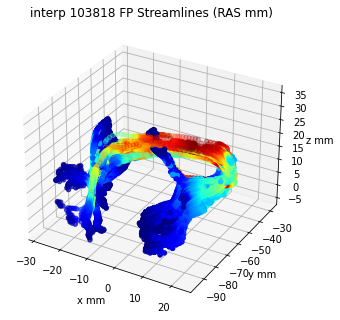

In [35]:
values = np.array(values_from_volume(scalar_data, fgarray, tractogram.affine))

if use_afq_profile:
    mean_values = afq_profile(
        scalar_data,
        tractogram.streamlines,
        tractogram.affine,
        weights=gaussian_weights(tractogram.streamlines)
    )
else:
    mean_values = np.mean(values, axis=0)

rewarped_fgarray = [None] * len(tractogram.streamlines)
interp_fgarray = [None] *  len(tractogram.streamlines)

for streamline_idx in range(len(tractogram.streamlines)):
    x = fgarray[streamline_idx][:,0]
    y = fgarray[streamline_idx][:,1]
    z = fgarray[streamline_idx][:,2]
    
    tck, u = splprep([x, y, z], s=0)

    # could reuse from above
    target_nodes = warp_target_nodes(values[streamline_idx], mean_values)

    new_points = splev(target_nodes/n_points, tck)
    rewarped_fgarray[streamline_idx] = np.array(new_points).T
    
#     u = minSum(target_nodes/n_points)
    u = replace_duplicates_with_geometric(target_nodes)
    u = u/n_points
    new_points = splev(u, tck)
    interp_fgarray[streamline_idx] = np.array(new_points).T
    
#     if random_streamline_idx == streamline_idx:
#         print(target_nodes)
#         print(target_nodes/n_points)
#         print(rewarped_fgarray[streamline_idx])
#         print(u)
#         print(interp_fgarray[streamline_idx])

# plot_bundle(f'original {subject} {bundle_name}', fgarray)
# plot_bundle(f'warped {subject} {bundle_name}', warped_fgarray)
# plot_bundle(f'rewarped {subject} {bundle_name}', rewarped_fgarray)
plot_bundle(f'interp {subject} {bundle_name}', interp_fgarray)

if show_random_streamline:
    plot_streamline(f'original {subject} {bundle_name}', fgarray, random_streamline_idx)
    plot_streamline(f'warped {subject} {bundle_name}', warped_fgarray, random_streamline_idx)
    # plot_streamline(f'rewarped {subject} {bundle_name}', rewarped_fgarray, random_streamline_idx)
    plot_streamline(f'interp {subject} {bundle_name}', interp_fgarray, random_streamline_idx)

#### TODO: Novel Alternative Visualization

Want to visulalize the dispersion across nodes:

- Plot the median at each node (instead of individual streamlines as below)

- Then scale the size of the point based on the determinate of the covariance matrix

Could then plot both before and after warping on same chart

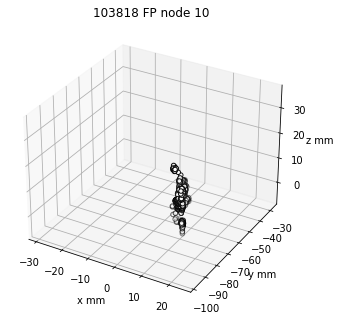

In [36]:
plot_node(f'{subject} {bundle_name}', fgarray, 10)

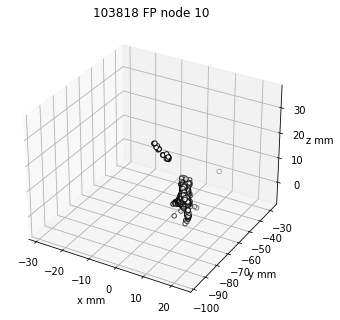

In [37]:
plot_node(f'{subject} {bundle_name}', warped_fgarray, 10)